In [1]:
import os, shutil, random, math
from PIL import Image
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.regularizers import l2, l1
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback

path = '/notebook/CJ/'
HOME_DIR = path+'fed_detect/'
DATA_DIR = HOME_DIR+'fr_rotate/'
RESULTS_DIR = DATA_DIR+'results/'
TRAIN_DIR = DATA_DIR+'train/'
VAL_DIR = DATA_DIR+'valid/'
TEST_DIR = DATA_DIR+'test/'

Using TensorFlow backend.


Show number of files in training/validation directories

In [2]:
train_class_folders = ([name for name in os.listdir(TRAIN_DIR)
            if os.path.isdir(os.path.join(TRAIN_DIR, name))]) # Get all directories 
val_class_folders = ([name for name in os.listdir(VAL_DIR)
            if os.path.isdir(os.path.join(VAL_DIR, name))])

val_content_len = []
for folder in val_class_folders:
    contents = os.listdir(os.path.join(VAL_DIR,folder)) # Get list of contents
    val_content_len.append(len(contents))
    print(os.path.join(VAL_DIR,folder),str(len(contents))+' files')

train_content_len = []
for folder in train_class_folders:
    contents = os.listdir(os.path.join(TRAIN_DIR,folder)) # Get list of contents
    train_content_len.append(len(contents))
    print(os.path.join(TRAIN_DIR,folder),str(len(contents))+' files')

('/notebook/CJ/fed_detect/fr_rotate/valid/upright', '439 files')
('/notebook/CJ/fed_detect/fr_rotate/valid/rotated', '437 files')
('/notebook/CJ/fed_detect/fr_rotate/train/upright', '2183 files')
('/notebook/CJ/fed_detect/fr_rotate/train/rotated', '1891 files')


Make sure validation directories exist (else create them)

In [3]:
if len(val_class_folders)==0:
    for folder in train_class_folders:
        os.mkdir(os.path.join(VAL_DIR,folder))
        print('Making directory: '+os.path.join(VAL_DIR,folder))

Rotate upright images to even out numbers between rotated vs non-rotated classes

In [8]:
figs = os.listdir(TRAIN_DIR+'upright/')
rot_figs = os.listdir(TRAIN_DIR+'rotated/')
shuffle(figs)
shuffle(rot_figs)

for i in figs[:-len(rot_figs)]:
    # Load the original image
    img = Image.open(TRAIN_DIR+'upright/'+i)
    # Counterclockwise rotation
    img = img.rotate(90)
    
    # Save rotated image
    img.save(TRAIN_DIR+'rotated/'+i[:-4]+'_rot'+i[-4:])
    print(i[:-4]+'_rot'+i[-4:]+' saved')

EP28DE15.004_rot.png saved
ER05JA17.290_rot.png saved
EP10DE15.069_rot.png saved
EN26MY17.003_rot.png saved
EP11JA17.011_rot.png saved
EP22OC15.005_rot.png saved
ER05JA17.184_rot.png saved
ER05JA17.019_rot.png saved
ER03NO15.229_rot.png saved
ER05JA17.017_rot.png saved
EN03NO15.134_rot.png saved
EN24JA17.003_rot.png saved
EN24MR16.005_rot.png saved
EN22MY17.027_rot.png saved
EN24MY17.018_rot.png saved
EN03MR16.006_rot.png saved
ER05JA17.191_rot.png saved
EN12MY17.005_rot.png saved
EP11JA17.010_rot.png saved
EN07AP17.002_rot.png saved
EP27NO15.004_rot.png saved
ER05JA17.107_rot.png saved
EP19OC15.010_rot.png saved
EP27NO15.011_rot.png saved
EN03NO15.128_rot.png saved
ED14JA16.004_rot.png saved
EP09NO15.402_rot.png saved
EN07AP16.020_rot.png saved
EN28AP17.042_rot.png saved
EN24MY17.012_rot.png saved
EP30MY17.003_rot.png saved
EN16MR17.011_rot.png saved
ER05JA17.003_rot.png saved
EN03NO15.105_rot.png saved
EN22MY17.000_rot.png saved
EN19MY17.003_rot.png saved
EN28MR16.036_rot.png saved
E

EN03NO15.102_rot.png saved
EN30MR16.284_rot.png saved
ER05JA17.127_rot.png saved
EN03NO15.163_rot.png saved
EP09NO15.441_rot.png saved
EN28AP17.024_rot.png saved
EP09NO15.097_rot.png saved
EP09NO15.502_rot.png saved
ER05JA17.001_rot.png saved
EP09NO15.261_rot.png saved
EN25MR16.278_rot.png saved
EN07AP16.010_rot.png saved
EN25MR16.185_rot.png saved
EN29DE15.000_rot.png saved
EN03NO15.218_rot.png saved
EN25MR16.288_rot.png saved
EN27AP17.003_rot.png saved
ED18FE16.000_rot.png saved
ER05JA17.276_rot.png saved
ER05JA17.110_rot.png saved
EN30MR16.282_rot.png saved
EN03NO15.175_rot.png saved
EN03MR16.036_rot.png saved
EP09NO15.298_rot.png saved
EP19JA17.006_rot.png saved
EN07MR16.008_rot.png saved
EP09NO15.284_rot.png saved
ER23JA17.005_rot.png saved
EP07JN17.001_rot.png saved
EN03MR16.015_rot.png saved
EN28AP17.027_rot.png saved
EP09NO15.070_rot.png saved
EN29OC15.013_rot.png saved
EN12JA16.000_rot.png saved
EP10DE15.022_rot.png saved
EN23FE16.000_rot.png saved
ED18JA17.052_rot.png saved
E

Enforce training/validation split

In [31]:
validation_split = 0.2

# Check difference between number of files in training v. validation set
target_val_size = [int((x+y)*validation_split) for x,y in zip(train_content_len,val_content_len)]
split_diff = [int(abs(x-y)) for x,y in zip(val_content_len,target_val_size)]

# Enforce train/validate split
if any(t!=0 for t in split_diff):
    
    for i,folder in enumerate(train_class_folders):
        contents = os.listdir(os.path.join(TRAIN_DIR,folder)) # Get list of contents
            
        # In-place shuffle
        random.shuffle(contents)
        print('Moving '+str(split_diff[i])+' files')
        
        for file_name in contents[:split_diff[i]]:
            full_file_name = os.path.join(TRAIN_DIR, folder, file_name)
            
            if (os.path.isfile(full_file_name)):
                #shutil.move(full_file_name, os.path.join(VAL_DIR, folder))
                pass

Moving 85 files
Moving 28 files


Plot examples of each class of input image (and save figure to .png)

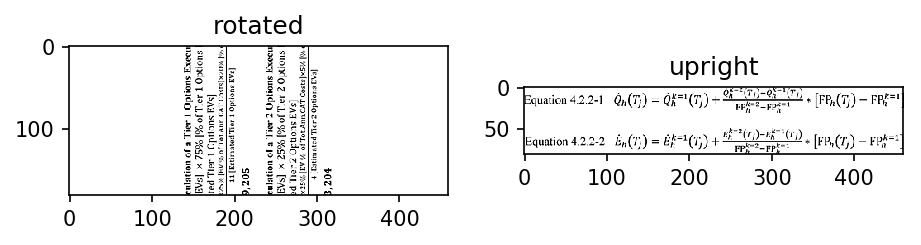

In [4]:
%matplotlib inline

fig = plt.figure(figsize=(15, 15), dpi=150)

path = TRAIN_DIR

for i,folder in enumerate(sorted(train_class_folders)):
    
    ax = fig.add_subplot(3, 4, i+1) # Add sub-axes

    contents = os.listdir(os.path.join(path,folder)) # Get list of contents
    
    # Show image from each class 
    ax.set_title(folder)
    ax.imshow(Image.open(os.path.join(path,folder,contents[0])))

fig.savefig(os.path.join(RESULTS_DIR,'training_class_examples.png'))


Define model parameters

In [3]:
batch_size = 32
epoch_count = 3
input_shape = (256,256,3)
valid_steps = 75 # Validation steps
output_dim = 1 # Binary classification task

learning_rate = 1e-4

fc_layer_size = 256

Use ImageDataGenerator to read images from directories

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Rescale images by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   height_shift_range=0.025,
                                   channel_shift_range=10,
                                   width_shift_range=0.05)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(     
    TRAIN_DIR,  # Target directory   
    shuffle=True,       
    target_size=input_shape[:-1],
    batch_size=batch_size,       
    class_mode='binary'
    )
valid_generator = valid_datagen.flow_from_directory(
    VAL_DIR,
    shuffle=True,
    target_size=input_shape[:-1],
    batch_size=batch_size,
    class_mode='binary'
    )
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    shuffle=False,
    target_size=input_shape[:-1],
    batch_size=batch_size,
    class_mode='binary'
    )

# Save category names to file
class_names = train_generator.class_indices.items()
np.save(os.path.join(RESULTS_DIR, 'class_names.npy'), class_names)

Found 4074 images belonging to 2 classes.
Found 876 images belonging to 2 classes.
Found 1311 images belonging to 1 classes.


In [5]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

('data batch shape:', (32, 256, 256, 3))
('labels batch shape:', (32,))


In [6]:
def plot_save_history(history, lr_history, savename):

    fig = plt.figure()
    
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))
    
    ax = fig.add_subplot(3, 1, 1) # Add sub-axes
    ax.plot(epochs, acc, 'b')
    ax.plot(epochs, val_acc, 'bo')
    ax.set_xticks(epochs)
    ax.set_title('Training and validation accuracy')
    
    ax = fig.add_subplot(3, 1, 2) # Add sub-axes
    ax.plot(epochs, loss, 'b')
    ax.plot(epochs, val_loss, 'bo')
    ax.set_xticks(epochs)
    ax.set_title('Training and validation loss')
    
    ax = fig.add_subplot(3, 1, 3) # Add sub-axes
    ax.plot(epochs, lr_history, 'b')
    ax.set_xticks(epochs)
    ax.set_yticks(np.unique(loss_history.lr)) # .tolist()
    ax.set_title('Learning rate')
    ax.set_xlabel('epoch')
    #ax.ticklabel_format(style='sci', axis='y')
    # ["%.1e" % x for x in np.unique(loss_history.lr).tolist()]
    
    plt.show()
    fig.savefig(savename) # , figsize=(5, 5), dpi=150

In [7]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        
# Create learning rate schedules
def step_decay(epoch):
    initial_lrate = learning_rate
    drop = 0.5
    epochs_drop = math.floor(epoch_count/3.0)
    return(initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop)))

def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    return(initial_lrate * np.exp(-k*epoch))

Generate classifier model

In [14]:
lin_model = Sequential([
        BatchNormalization(axis=1, input_shape=input_shape),
        Flatten(),
        Dense(output_dim, activation='sigmoid') #kernel_regularizer=l2(0.01)
    ])

lin_model.compile(RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

lin_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 256, 256, 3)       1024      
_________________________________________________________________
flatten_2 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 196609    
Total params: 197,633
Trainable params: 197,121
Non-trainable params: 512
_________________________________________________________________


Fit our model using batch generator

Epoch 1/3
128/127 [==============================] - 63s 492ms/step - loss: 0.2787 - acc: 0.9204 - val_loss: 0.1552 - val_acc: 0.9475
Epoch 2/3
128/127 [==============================] - 59s 464ms/step - loss: 0.1987 - acc: 0.9288 - val_loss: 0.1740 - val_acc: 0.9395
Epoch 3/3
128/127 [==============================] - 60s 465ms/step - loss: 0.1652 - acc: 0.9373 - val_loss: 0.1360 - val_acc: 0.9521


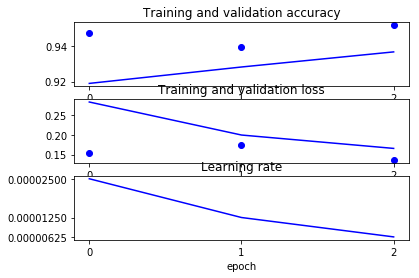

In [15]:
# Create callbacks
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay) # exp_decay

history = lin_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[loss_history,lrate]
                )

# Save model
lin_model.save(os.path.join(RESULTS_DIR,'lin_model.h5'))

# Plot (and save) model performance
plot_save_history(history.history, loss_history.lr, os.path.join(RESULTS_DIR,'lin_model.png'))

# loss: 0.1652 - acc: 0.9373 - val_loss: 0.1360 - val_acc: 0.9521

Epoch 1/3
128/127 [==============================] - 112s 874ms/step - loss: 0.1444 - acc: 0.9560 - val_loss: 0.2558 - val_acc: 0.9680
Epoch 2/3
128/127 [==============================] - 113s 883ms/step - loss: 0.0589 - acc: 0.9825 - val_loss: 0.0636 - val_acc: 0.9863
Epoch 3/3
128/127 [==============================] - 113s 883ms/step - loss: 0.0465 - acc: 0.9846 - val_loss: 0.0343 - val_acc: 0.9920


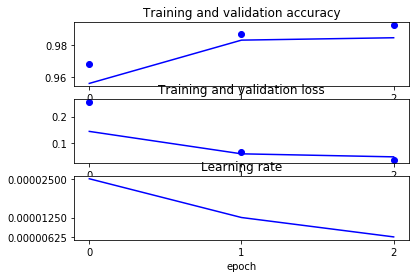

In [8]:
# Create callbacks
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay) # exp_decay

conv_model = Sequential([
            BatchNormalization(axis=1, input_shape=input_shape),
            Conv2D(32,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Conv2D(64,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dropout(0.5),
            Dense(fc_layer_size, activation='relu'),
            BatchNormalization(),
            Dense(output_dim, activation='sigmoid') # softmax
        ])

conv_model.compile(optimizer=Adam(), # lr=1e-4, decay=1e-4/10
                loss='binary_crossentropy',
                metrics=['accuracy']
                  )

history = conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[loss_history,lrate]
                   )

# Save model
conv_model.save(os.path.join(RESULTS_DIR,'conv_model.h5'))

# Plot (and save) model performance
plot_save_history(history.history, loss_history.lr, os.path.join(RESULTS_DIR,'conv_model.png'))

# loss: 0.0465 - acc: 0.9846 - val_loss: 0.0343 - val_acc: 0.9920

Instantiate the VGG16 convolutional base

In [10]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

conv_base.trainable = False # Freeze the convolutional base

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

Add a densely-connected classifier on top of the convolutional base

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 23,103,809
Trainable params: 8,389,121
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/3
128/127 [==============================] - 67s 523ms/step - loss: 0.1113 - acc: 0.9550 - val_loss: 0.0317 - val_acc: 0.9920
Epoch 2/3
128/127 [==============================] - 61s 475ms/step - loss: 0.0238 - acc: 0.9950 - val_loss: 0.0238 - va

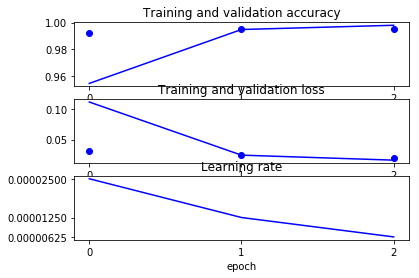

In [12]:
# Create callbacks
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay) # exp_decay

pt_froz_conv_model = Sequential()
pt_froz_conv_model.add(conv_base)
pt_froz_conv_model.add(Flatten())
pt_froz_conv_model.add(Dense(fc_layer_size, activation='relu'))
pt_froz_conv_model.add(Dense(output_dim, activation='sigmoid'))

pt_froz_conv_model.summary()

pt_froz_conv_model.compile(optimizer=Adam(), # lr=1e-4, decay=1e-4/10
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

history = pt_froz_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[loss_history, lrate]
                   )

# Save model
pt_froz_conv_model.save(os.path.join(RESULTS_DIR,'pt_froz_conv_model.h5'))

# Plot (and save) model performance
plot_save_history(history.history, loss_history.lr, os.path.join(RESULTS_DIR,'pt_froz_conv_model.png'))

In [13]:
# Un-freeze the convolutional base
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:        
        layer.trainable = False

Pre-trained convolutional network, un-frozen convolutional base

Epoch 1/3
128/127 [==============================] - 66s 513ms/step - loss: 0.0653 - acc: 0.9760 - val_loss: 0.0192 - val_acc: 0.9932
Epoch 2/3
128/127 [==============================] - 61s 477ms/step - loss: 0.0091 - acc: 0.9976 - val_loss: 0.0064 - val_acc: 0.9977
Epoch 3/3
128/127 [==============================] - 61s 476ms/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0035 - val_acc: 0.9977


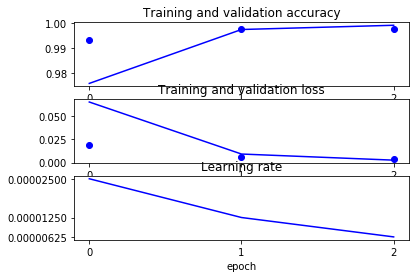

In [14]:
# Create callbacks
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay) # exp_decay

pt_conv_model = Sequential()
pt_conv_model.add(conv_base)
pt_conv_model.add(Flatten())
pt_conv_model.add(Dense(fc_layer_size, activation='relu'))
pt_conv_model.add(Dense(output_dim, activation='sigmoid')) # , kernel_regularizer=l2(0.01)

pt_conv_model.compile(optimizer=Adam(),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

history = pt_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[loss_history, lrate]
                   )

# Save model
pt_conv_model.save_weights(os.path.join(RESULTS_DIR,'pt_conv_weights.h5'))

# Plot (and save) model performance
plot_save_history(history.history, loss_history.lr, os.path.join(RESULTS_DIR,'pt_conv_model.png'))

# Adam loss: 0.0343 - acc: 0.9909 - val_loss: 0.1825 - val_acc: 0.9691

Pre-trained convolutional network with drop-out, partially un-frozen convolutional base

Epoch 1/3
128/127 [==============================] - 66s 513ms/step - loss: 0.0309 - acc: 0.9899 - val_loss: 0.0086 - val_acc: 0.9977
Epoch 2/3
128/127 [==============================] - 61s 476ms/step - loss: 0.0046 - acc: 0.9990 - val_loss: 0.0052 - val_acc: 0.9989
Epoch 3/3
128/127 [==============================] - 61s 477ms/step - loss: 0.0030 - acc: 0.9993 - val_loss: 3.5325e-04 - val_acc: 1.0000


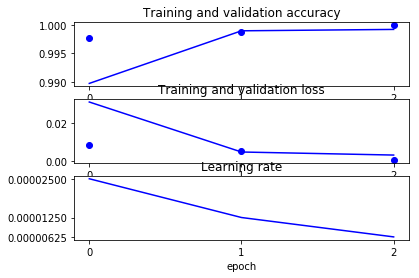

In [15]:
# Create callbacks
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay) # exp_decay

# Add drop-out
pt_dr_conv_model = Sequential()
pt_dr_conv_model.add(conv_base)
pt_dr_conv_model.add(Flatten())
pt_dr_conv_model.add(Dropout(0.5))
pt_dr_conv_model.add(Dense(fc_layer_size, activation='relu'))
pt_dr_conv_model.add(Dense(output_dim,
                           activation='sigmoid')) # , kernel_regularizer=l2(1e-2), activation='sigmoid'

pt_dr_conv_model.compile(optimizer=Adam(),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

history = pt_dr_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[loss_history, lrate])

# Save model weights
pt_dr_conv_model.save(os.path.join(RESULTS_DIR,'pt_dr_conv_model.h5'))
#pt_dr_conv_model.save_weights(os.path.join(RESULTS_DIR,'pt_dr_conv_weights.h5'))

# Plot (and save) model performance
plot_save_history(history.history, loss_history.lr, os.path.join(RESULTS_DIR, 'pt_dr_conv_model.png'))

# loss: 0.1379 - acc: 0.9883 - val_loss: 0.4270 - val_acc: 0.9578

In [24]:
from keras.models import load_model

# Load a compiled model
loaded_model = load_model(os.path.join(RESULTS_DIR,'pt_dr_conv_model.h5'))

## Load model weights
#pt_dr_conv_model.load_weights(os.path.join(RESULTS_DIR,'pt_dr_conv_weights.h5'))

### Visualize convnet filter

In [26]:
pt_dr_conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 23,103,809
Trainable params: 15,468,545
Non-trainable params: 7,635,264
_________________________________________________________________


In [37]:
from keras import backend as K

model = pt_conv_model # pt_dr_conv_model
'''
# Define the loss tensor for filter visualization
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor
grads = K.gradients(loss, model.input)[0] # Add 1e-5 before dividing so as to avoid accidentally dividing by 0
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
'''
pt_dr_conv_model.summary()
print(pt_dr_conv_model.layers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 23,103,809
Trainable params: 15,468,545
Non-trainable params: 7,635,264
_________________________________________________________________
[<keras.engine.training.Model object at 0x7fe1b8048fd0>, <keras.layers.core.Flatten object at 0x7fe1868c3c10>, <keras.laye

In [34]:
'''
# Define a Keras function for fetching Numpy output values, given Numpy input values
iterate = K.function([model.input], [loss, grads])

# Maximize loss via stochastic gradient descent over the input parameters
# We start from a gray image with some noise
input_img_data = np.random.random((1,)+input_shape) * 20 + 128.
# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step
'''

# Utility function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Function to generate filter visualizations
def generate_pattern(layer_name, filter_index, size=input_shape[0]):
    # Build a loss function that maximizes the activation of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]
    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

## Show example filter
#plt.imshow(generate_pattern('block3_conv1', 0))
#plt.show()

NameError: name 'loss' is not defined

Generate grid of all filter response patterns in a layer

In [31]:
def plot_filters(layer_name):
    size = input_shape[0]
    margin = 5
    rows = 6
    cols = 6

    # Create an empty (black) image where we will store our results
    results = np.zeros((rows * size + (rows-1) * margin, cols * size + (cols-1) * margin, 3))
    for i in range(rows):
        # Iterate over the rows of our results grid
        for j in range(cols):
            # Iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * cols), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

In [32]:
layer_name = 'block1_conv1'
plot_filters(layer_name)

ValueError: No such layer: block1_conv1

In [21]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [22]:
layer_name = 'block1_conv2'
plot_filters(layer_name)

ValueError: No such layer: block1_conv2

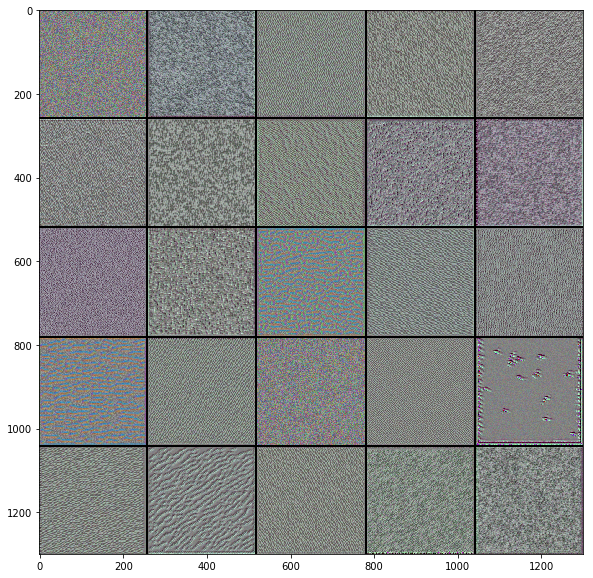

In [33]:
layer_name = 'block2_conv1'
plot_filters(layer_name)

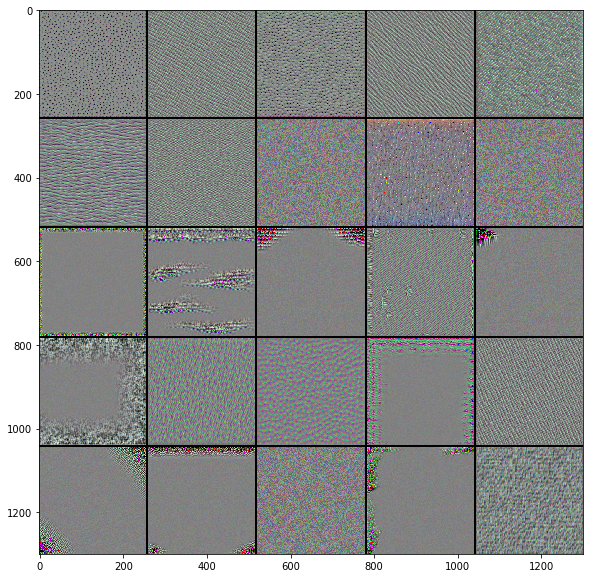

In [34]:
layer_name = 'block3_conv1'
plot_filters(layer_name)

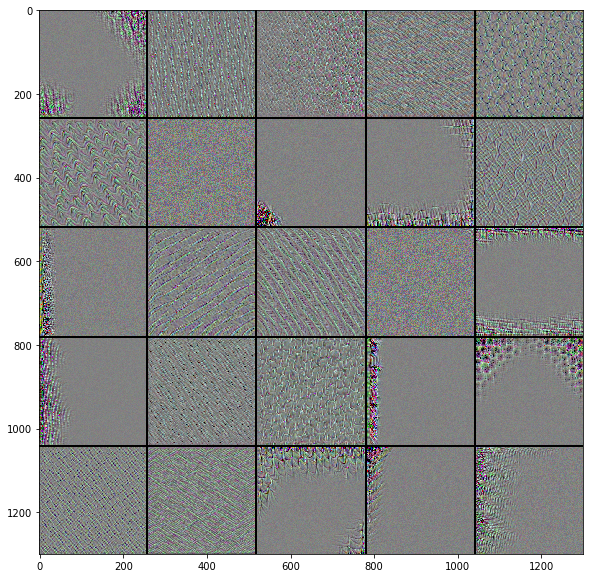

In [35]:
layer_name = 'block4_conv1'
plot_filters(layer_name)

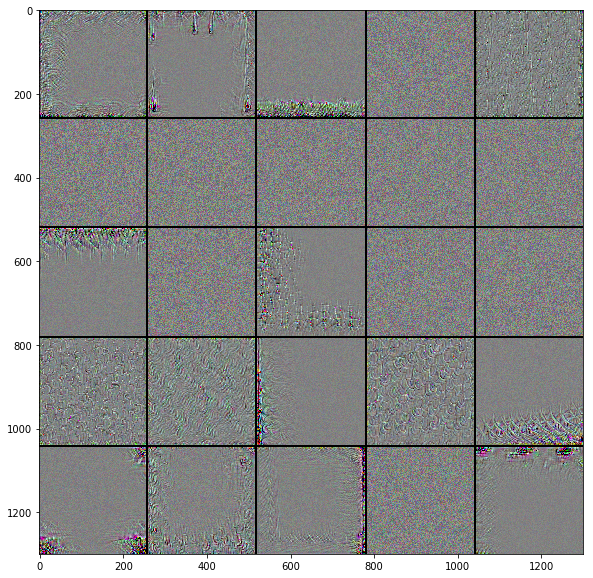

In [36]:
layer_name = 'block5_conv1'
plot_filters(layer_name)

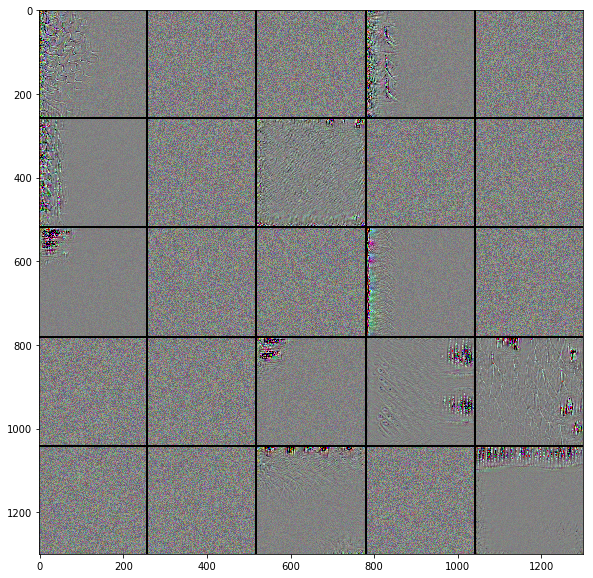

In [37]:
layer_name = 'block5_conv2'
plot_filters(layer_name)

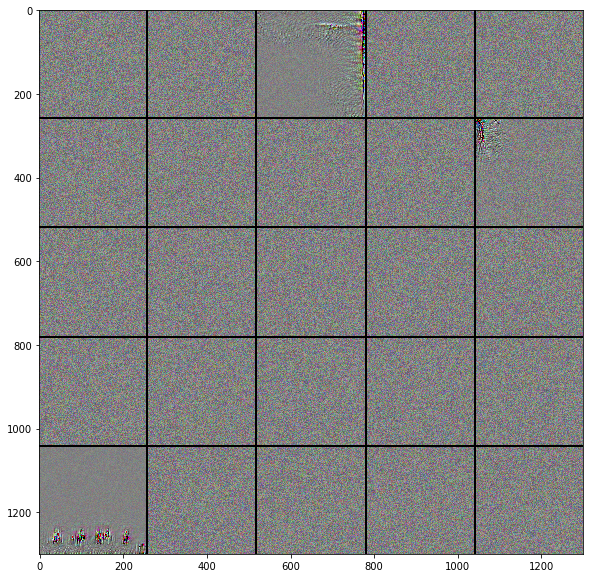

In [38]:
layer_name = 'block5_conv3'
plot_filters(layer_name)

### Generate confusion matrix

In [39]:
conf_generator = valid_datagen.flow_from_directory(
    VAL_DIR,
    shuffle=True,
    target_size=input_shape[:-1],
    batch_size=128,
    class_mode='categorical'
    )

for i in range(0, 3):
    # Test out classifier
    inverted_dict = dict([[v,k] for k,v in conf_generator.class_indices.items()])

    im_vals,class_val = conf_generator.next()
    predictions = pt_dr_conv_model.predict(im_vals)

    # Show image
    plt.imshow(im_vals[i])
    plt.show()

    y_test = np.argmax(class_val, axis=1)
    y_pred = np.argmax(predictions, axis=1)

    # Show actual category
    category_val = inverted_dict[y_test[i]]
    print('Actual class: '+category_val)

    # Show predicted category
    class_preds = inverted_dict[y_pred[i]]
    print('Predicted class: '+class_preds)

NameError: name 'straight_generator' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, size='x-large', weight='bold')
    plt.yticks(tick_marks, classes, size='x-large', weight='bold')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], #  "%.3f" % 
                 horizontalalignment="center",
                 size="x-large",
                 weight="bold",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size='x-large', weight='bold', style='italic')
    plt.xlabel('Predicted label', size='x-large', weight='bold', style='italic')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(cnf_matrix, classes=train_class_folders,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.show()
fig.savefig(RESULTS_DIR+'conf_matrix.png')

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.savefig(os.path.join(RESULTS_DIR,'conf_matrix.png')) # , figsize=(5, 5), dpi=150

Instantiate resnet model

In [40]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.applications.resnet50 import ResNet50

# load base model
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=input_shape)

In [41]:
# number of classes
nb_classes = 1

# append classification layer
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
final_output = Dense(nb_classes, activation='sigmoid', kernel_regularizer=l2(0.001))(x) 

# create the new model
model = Model(input=base_model.input, output=final_output)

# model compilation
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # This is added back by InteractiveShellApp.init_path()


In [42]:
# callbacks
checkpointer = ModelCheckpoint(
    filepath=RESULTS_DIR+'resnet_weights.h5',
    save_best_only=True
)
early_stopping = EarlyStopping(patience=2)
tensorboard = TensorBoard()
# model_checkpoint = ModelCheckpoint(results_path+'weights.h5', monitor='val_loss', save_best_only=True)

In [44]:
#model.optimizer.lr = 1e-5

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=5, # epoch_count
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[checkpointer, early_stopping, tensorboard]
                   )

Epoch 1/5
109/109 [==============================] - 103s - loss: 0.0467 - acc: 0.9885 - val_loss: 4.1954 - val_acc: 0.5013
Epoch 2/5
109/109 [==============================] - 102s - loss: 0.0424 - acc: 0.9891 - val_loss: 2.2792 - val_acc: 0.5022
Epoch 3/5
109/109 [==============================] - 101s - loss: 0.0240 - acc: 0.9923 - val_loss: 1.1274 - val_acc: 0.4997
Epoch 4/5
109/109 [==============================] - 103s - loss: 0.0535 - acc: 0.9883 - val_loss: 0.4352 - val_acc: 0.8866
Epoch 5/5
109/109 [==============================] - 103s - loss: 0.0403 - acc: 0.9877 - val_loss: 0.2601 - val_acc: 0.9569


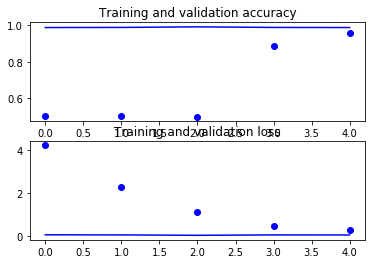

In [46]:
# Save model weights
model.save_weights(os.path.join(RESULTS_DIR,'fedreg_resnet_model.h5'))

# Plot (and save) model performance
plot_save_history(history.history, os.path.join(RESULTS_DIR,'resnet_model.png'))